In [1]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

%matplotlib inline

# Load Dataset

In [3]:
item_to_id = pd.read_csv('item_to_id.csv')
item_to_id.head()

,Item_name,Item_id
0,coffee,43
1,tea,23
2,juice,38
3,soda,9
4,sandwich loaves,39


In [4]:
item_to_id.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 2 columns):
Item_name    48 non-null object
Item_id      48 non-null int64
dtypes: int64(1), object(1)
memory usage: 848.0+ bytes


In [5]:
# Unique ids
print(sorted(item_to_id['Item_id'].unique()))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48]


In [6]:
history = pd.read_csv('purchase_history.csv')
history.head()

,user_id,id
0,222087,"27,26"
1,1343649,"6,47,17"
2,404134,"18,12,23,22,27,43,38,20,35,1"
3,1110200,"9,23,2,20,26,47,37"
4,224107,"31,18,5,13,1,21,48,16,26,2,44,32,20,37,42,35,4..."


In [7]:
history.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39474 entries, 0 to 39473
Data columns (total 2 columns):
user_id    39474 non-null int64
id         39474 non-null object
dtypes: int64(1), object(1)
memory usage: 616.9+ KB


# Data Processing

In [8]:
# ref: https://github.com/stasi009/TakeHomeDataChallenges/blob/master/09.ClusterGrocery/cluster_grocery.ipynb
def id_to_item(df):
    """ function to convert id into counts """
    # 'sum' here is adding two lists into one big list
    ids = df['id'].str.split(',').sum()
    id_list = [0 for i in range(1, 49)]
    for i in ids:
        id_list[int(i) - 1] += 1
        
    return pd.Series(id_list, index=list(range(1, 49)))

In [9]:
# get user_item count matrix
user_item_count = history.groupby('user_id').apply(id_to_item)

user_item_count.head()

,1,2,3,4,5,6,7,8,9,10,...,39,40,41,42,43,44,45,46,47,48
user_id,,,,,,,,,,,,,,,,,,,,,
47,0,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,1,1,1,0,0
68,0,0,0,0,0,1,0,0,0,1,...,1,0,0,1,0,0,0,0,0,0
113,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,1,0,0
123,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
223,1,1,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0


# Question 1

### The customer who bought the most items overall in her lifetime

In [10]:
user_count = user_item_count.sum(axis=1).reset_index().rename(columns={0: 'count'})
user_count.sort_values(by='count', ascending=False).head()

,user_id,count
4445,269335,72
6111,367872,70
6623,397623,64
9918,599172,64
6291,377284,63


So the customer who bought the most items is 269335 with 72 items

### For each item, the customer who bought that product the most

In [11]:
item_user_most = user_item_count.apply(np.argmax, axis=0).reset_index()
item_user_most = item_user_most.rename(columns={'index': 'Item_id', 0: 'User_id'})

df = pd.merge(left=item_user_most, right=item_to_id, on='Item_id', how='left')
df[['Item_id', 'Item_name', 'User_id']]

,Item_id,Item_name,User_id
0,1,sugar,31625
1,2,lettuce,31625
2,3,pet items,154960
3,4,baby items,5289
4,5,waffles,217277
5,6,poultry,334664
6,7,sandwich bags,175865
7,8,butter,151926
8,9,soda,269335
9,10,carrots,618914


# Question 2

In [12]:
# define the feature matrix: item_id, user_id
feature = user_item_count.T
feature.head()

user_id,47,68,113,123,223,281,323,394,420,453,...,1499502,1499523,1499563,1499702,1499727,1499730,1499778,1499797,1499817,1499974
1,0,0,0,0,1,0,1,1,0,1,...,0,0,1,0,0,0,0,0,1,0
2,1,0,0,0,1,0,0,1,1,1,...,1,0,1,0,0,0,1,0,2,0
3,1,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,1,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [13]:
# determine the best number of clusters
clusters = range(2, 30)
inertias = []
silhouettes = []

for n_clusters in clusters:
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42, n_jobs=-1)
    kmeans = kmeans.fit(feature)
    label = kmeans.predict(feature)
    
    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(feature, label))

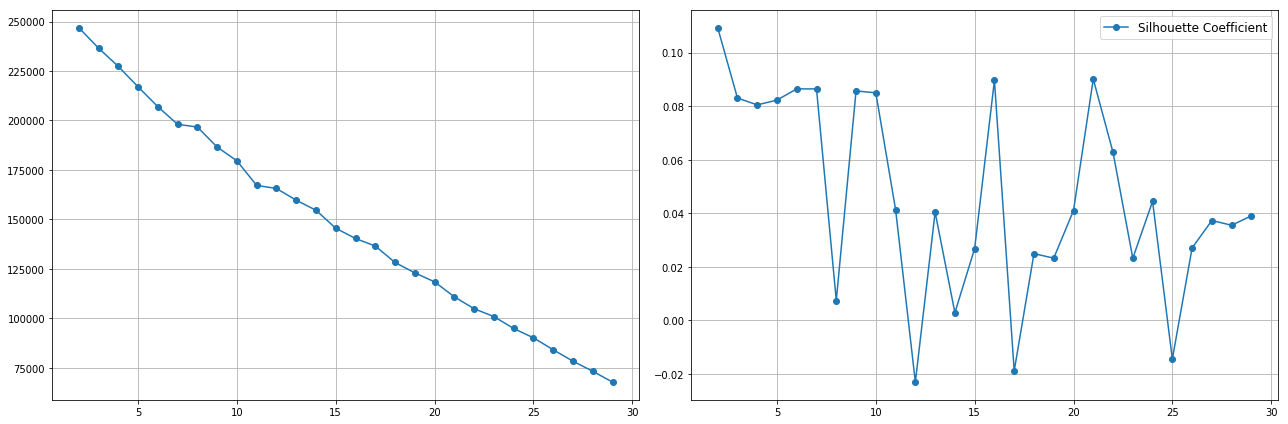

In [14]:
# visualization
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
ax[0].plot(clusters, inertias, 'o-', label='Sum of Squared Distances')
ax[0].grid(True)
ax[1].plot(clusters, silhouettes, 'o-', label='Silhouette Coefficient')
ax[1].grid(True)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

It seems 21 clusters is the best choice. Now, let's apply PCA on the data and visualize the data.

In [15]:
# build K-Means model
kmeans = KMeans(n_clusters=21, init='k-means++', random_state=42, n_jobs=-1)
kmeans = kmeans.fit(feature)
label = kmeans.predict(feature)

In [22]:
# PCA for dimension reduction
pca = PCA(n_components=2, random_state=42)
pca = pca.fit(feature)
pca_feature = pca.transform(feature)

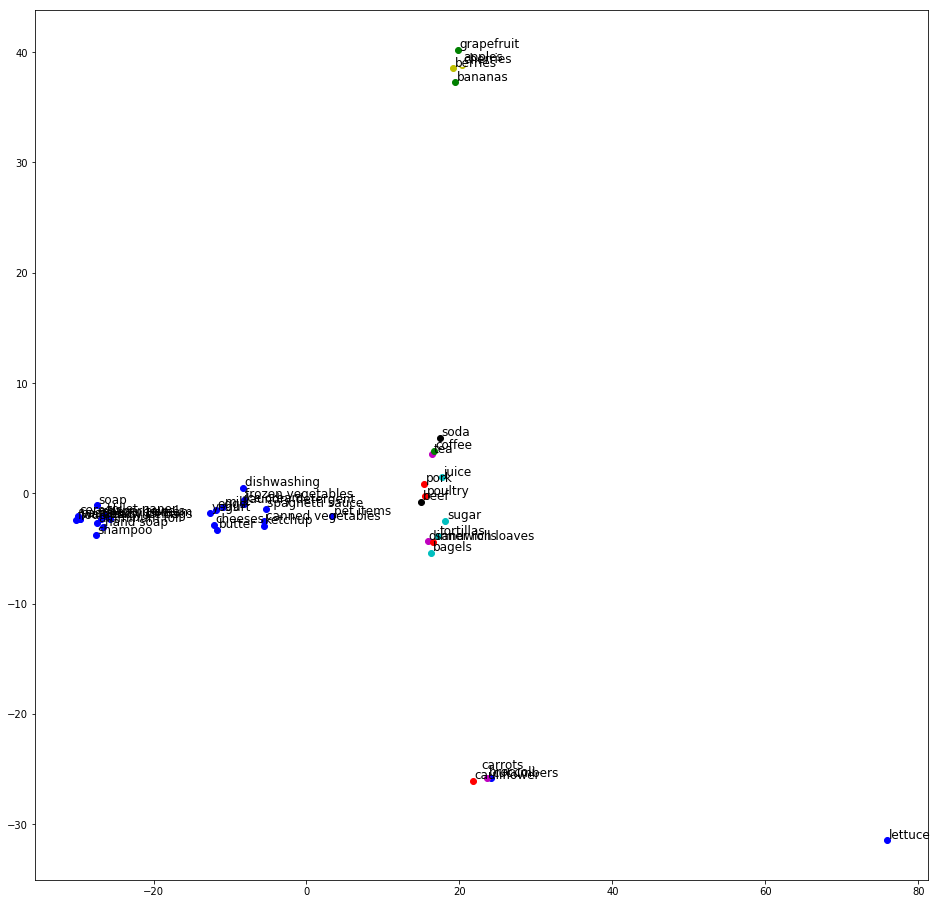

In [23]:
# visualization in 2D
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']

fig, ax = plt.subplots(figsize=(16, 16))
for j in range(len(pca_feature)):
    x = pca_feature[j][0]
    y = pca_feature[j][1]
    ax.plot(x, y, 'o', color=colors[label[j] % 8])
    name = item_to_id[item_to_id['Item_id'] == j + 1]['Item_name']
    ax.annotate(xy=(x+0.2, y+0.2), text=name.values[0], fontsize=12)

plt.show()

In [24]:
# print useful information
df = pd.DataFrame({'Item_id': list(range(1, 49)), 'label': label})
df = pd.merge(left=df, right=item_to_id, on='Item_id', how='left')

for i in range(0, 21):
    print(i, '\t', list(df[df['label'] == i]['Item_name']))

0 	 ['pet items', 'baby items', 'waffles', 'sandwich bags', 'butter', 'cereals', 'shampoo', 'eggs', 'aluminum foil', 'milk', 'laundry detergent', 'shaving cream', 'cheeses', 'frozen vegetables', 'paper towels', 'spaghetti sauce', 'dishwashing\xa0', 'canned vegetables', 'hand soap', 'flour', 'pasta', 'toilet paper', 'soap', 'ice cream', 'ketchup', 'yogurt']
1 	 ['bananas']
2 	 ['cauliflower']
3 	 ['sugar']
4 	 ['dinner rolls']
5 	 ['cherries']
6 	 ['beef']
7 	 ['carrots']
8 	 ['lettuce']
9 	 ['coffee']
10 	 ['poultry', 'pork']
11 	 ['bagels', 'tortillas']
12 	 ['broccoli']
13 	 ['berries']
14 	 ['soda']
15 	 ['apples']
16 	 ['cucumbers']
17 	 ['grapefruit']
18 	 ['sandwich loaves']
19 	 ['juice']
20 	 ['tea']


Above clustering is based on the raw feature, namely the user purchase for each item. There are other methods for this problem. For example, this notebook contains another method: [notebook link](https://github.com/stasi009/TakeHomeDataChallenges/blob/master/09.ClusterGrocery/cluster_grocery.ipynb).

With 21 clusters, some cluster looks very weird. Since there are only 48 different items, with one business expert in related area, it only take a few time to manually determine the best cluster numbers.